### Content Analysis Political - Supreme Court Posts
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("political/Topics_FB_Political_Posts_per_partysupreme_court.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(1340, 35)

In [5]:

posts.shape

(1340, 35)

In [6]:
posts['URL']

0       https://www.facebook.com/MexicanAmericansForBi...
1       https://www.facebook.com/latinosvstrump/posts/...
2       https://www.facebook.com/latinosvstrump/posts/...
3       https://www.facebook.com/latinosvstrump/posts/...
4       https://www.facebook.com/latinosvstrump/posts/...
                              ...                        
1335    https://www.facebook.com/groups/16256741844186...
1336    https://www.facebook.com/groups/16256741844186...
1337    https://www.facebook.com/groups/16256741844186...
1338    https://www.facebook.com/groups/16256741844186...
1339    https://www.facebook.com/groups/16256741844186...
Name: URL, Length: 1340, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-09-19 21:20:47 EDT
1    2020-09-24 20:07:04 EDT
2    2020-09-20 18:39:16 EDT
3    2020-10-14 07:01:14 EDT
4    2020-09-21 16:30:18 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-09-19 21:20:47-04:00
1      2020-09-24 20:07:04-04:00
2      2020-09-20 18:39:16-04:00
3      2020-10-14 07:01:14-04:00
4      2020-09-21 16:30:18-04:00
                  ...           
1335   2020-09-20 17:58:36-04:00
1336   2020-09-19 09:37:34-04:00
1337   2020-09-18 15:45:41-04:00
1338   2020-09-06 16:28:59-04:00
1339   2020-09-06 03:40:20-04:00
Name: converted_date, Length: 1340, dtype: datetime64[ns, tzlocal()]

In [11]:
posts['converted_date']=posts['converted_date'].dt.date

In [12]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,2
1,2020-08-20,4
2,2020-08-21,3
3,2020-08-22,2
4,2020-08-23,1
5,2020-08-24,1
6,2020-08-25,1
7,2020-08-26,3
8,2020-08-27,1
9,2020-08-28,1


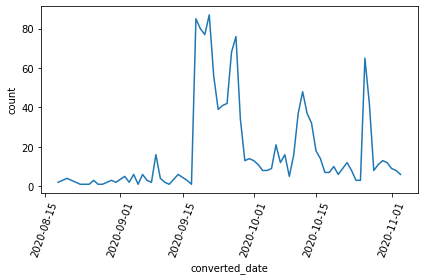

In [13]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [14]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
10,259,Latinos Contra Trump,latinosvstrump,1161597243956409,229530.0,2020-10-13 07:01:23 EDT,Link,47,37,42,...,¿Recuerdan al Juez del Supremo Acusado de Viol...,"Mientras se debate sobre su último nominado, e...",NaN,NaN,233,-1.74,"En su brutalidad, Trump ignora una poderosa RA...","En su brutalidad, Trump ignora una poderosa RA...",Democrat,2020-10-13


In [15]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [16]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [17]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [18]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
DONALD TRUMP PARA HISPANOS,129
Latinos Against Donald Trump,118
Latinos For Trump -California Group,108
Republican National Hispanic Assembly - Official Group,88
CARA - Cuban American Republican Alliance,68
Republican National Hispanic Assembly,57
Latinos For Trump.,50
Mexicans for Donald Trump,45
Republican National Hispanic Assembly of Florida,34


## Tokenize words and Clean-up text

In [19]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0       We honor the memory of Supreme Court Justice R...
1       Donald, recibirás del pueblo lo mismo que les ...
2       Esto es clave. Si es que ella cumple, estará f...
3       Si eres o tienes amigos mujeres, gays o de otr...
4       Cuídate el hígado Donny! Esas perretas de niño...
5       Todo depende de que los demócratas tomen al to...
6       Esto es algo que todos SABEN, pero nadie lo ha...
7       Todo en esta vida tiene consecuencias, pero qu...
8       Es tan grave el asunto que somos nosotros los ...
9       Nominada de Trump al Supremo Bajo Fuego por De...
10      En su brutalidad, Trump ignora una poderosa RA...
11      This is what happens when you stand up for civ...
12      El más asqueroso e indeseable de los Republica...
13      Todos conocemos la aversión de estos tipos por...
14      Biden straight forward and simple views on Gin...
15      Understanding history is key to preparing for ...
16      He did an incredible job and the difference wi...
17      Sólo u

In [20]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(1050,)

In [21]:
# Convert to list
data = content.cleanMessage.tolist()

In [22]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['we', 'honor', 'the', 'memory', 'of', 'supreme', 'court', 'justice', 'ruth', 'bader', 'ginsburg', 'but', 'to', 'do', 'so', 'we', 'must', 'also', 'honor', 'her', 'legacy', 'of', 'justice', 'and', 'equality', 'for', 'all', 'people', 'may', 'she', 'rest', 'in', 'peace', 'and', 'we', 'pray', 'congess', 'doesn', 'disgrace', 'her', 'memory', 'by', 'rushing', 'to', 'replace', 'her', 'the', 'nation', 'has', 'lost', 'an', 'iconic', 'leader', 'who', 'should', 'be', 'mourned', 'and', 'celebrated', 'photos', 'from', 'mexican', 'americans', 'for', 'bidens', 'post'], ['donald', 'recibiras', 'del', 'pueblo', 'lo', 'mismo', 'que', 'les', 'has', 'dado', 'esto', 'no', 'fue', 'nada', 'veras', 'el', 'de', 'noviembre', 'el', 'presidente', 'no', 'estara', 'contento', 'con', 'la', 'recepcion', 'que', 'recibio', 'esta', 'manana', 'en', 'la', 'corte', 'suprema', 'trump', 'recibe', 'abucheos', 'canticos', 'enojados', 'mientras', 'visitaba', 'el', 'ferretro', 'de', 'la', 'jueza', 'ruth', 'bader', 'ginsberg']]


#### Creating Bigram and Trigram Models

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['we', 'honor', 'the', 'memory', 'of', 'supreme', 'court', 'justice', 'ruth_bader_ginsburg', 'but', 'to', 'do', 'so', 'we', 'must', 'also', 'honor', 'her', 'legacy', 'of', 'justice', 'and', 'equality', 'for', 'all', 'people', 'may', 'she', 'rest', 'in', 'peace', 'and', 'we', 'pray', 'congess', 'doesn', 'disgrace', 'her', 'memory', 'by', 'rushing', 'to', 'replace', 'her', 'the', 'nation', 'has', 'lost', 'an', 'iconic', 'leader', 'who', 'should', 'be', 'mourned', 'and', 'celebrated', 'photos', 'from', 'mexican', 'americans', 'for', 'bidens', 'post']


## Remove Stopwords, Make Bigrams and Lemmatize

In [25]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [28]:
data_lemmatized[0]

['honor',
 'justice',
 'justice',
 'rest',
 'peace',
 'disgrace',
 'celebrated',
 'photos']

In [29]:
print(data_words_nostops[1:2])

[['donald', 'recibiras', 'pueblo', 'mismo', 'dado', 'veras', 'noviembre', 'presidente', 'estara', 'contento', 'recepcion', 'recibio', 'manana', 'corte', 'suprema', 'trump', 'recibe', 'abucheos', 'canticos', 'enojados', 'mientras', 'visitaba', 'ferretro', 'jueza', 'ruth', 'bader', 'ginsberg']]


## Bag of Words

In [30]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [31]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [32]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [33]:
final_dict.most_common(1000)

[('trump', 547),
 ('president / presidente', 284),
 ('juez', 209),
 ('votar', 183),
 ('justice', 176),
 ('decir', 145),
 ('ano', 144),
 ('hacer', 96),
 ('casa_blanca', 89),
 ('payaso', 86),
 ('democratas', 75),
 ('republicano', 71),
 ('elección', 71),
 ('democrats', 69),
 ('nuevo', 68),
 ('american / america', 68),
 ('mujer', 60),
 ('ley', 58),
 ('candidato', 57),
 ('political', 57),
 ('debatir', 56),
 ('personar', 55),
 ('nominar', 50),
 ('querer', 50),
 ('acusar', 48),
 ('legal', 48),
 ('judicial', 47),
 ('partir', 47),
 ('poder', 45),
 ('armar', 45),
 ('senado', 44),
 ('casar', 44),
 ('conservador', 43),
 ('federal', 42),
 ('unir', 41),
 ('ahora', 40),
 ('tambien', 40),
 ('solo', 38),
 ('democrata', 37),
 ('guerra', 37),
 ('menor', 36),
 ('familia', 36),
 ('senador', 35),
 ('despues', 35),
 ('sexual', 35),
 ('millón', 35),
 ('derecho', 34),
 ('abortar', 33),
 ('lograr', 33),
 ('hablar', 32),
 ('confirmar', 32),
 ('law', 32),
 ('necesitar', 32),
 ('historia', 32),
 ('dar', 31),
 ('su

In [34]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [35]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [36]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [37]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,2.214494
justice,2.940218
juez,3.342377
presidente,3.393149
votar,3.550778
democratas,3.879960
democrats,3.897054
america,3.914446
ano,3.987205
nuevo,3.987205


In [38]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [39]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
disgrace,0.461074
celebrated,0.417079
justice,0.373235
rest,0.365609
peace,0.347349
photos,0.347349
honor,0.314927


In [40]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(evento)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,unique_messages,counts
0,"radicalmente pro aborto el candidato presidencial demócrata joe biden habla durante una parada de la campaña en gettysburg, pensilvania, ee.uu., el 6 de octubre de 2020. (reuters/kevin lamarque) redacción bles– el lunes pasado, el candidato a presidente del partido demócrata, joe biden, participó de un evento con la... joe biden dice que hará que el aborto sea la ‘ley de la tierra’ si la corte suprema intenta revertir la legislación - libertad usa",1


### Repeated messages

In [41]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [42]:
##results.sort_values(by='Counts',ascending=False)

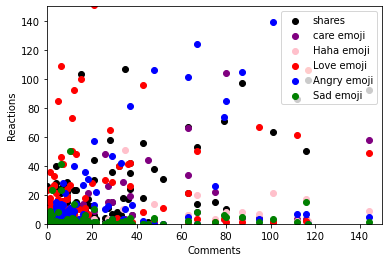

In [43]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [44]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1)]]


[[('celebrated', 1),
  ('disgrace', 1),
  ('honor', 1),
  ('justice', 2),
  ('peace', 1),
  ('photos', 1),
  ('rest', 1)]]

## Buiding the Topic Model

In [45]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [46]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.139*"decir" + 0.124*"juez" + 0.065*"elección" + 0.059*"nuevo" + '
  '0.049*"republicano" + 0.045*"senado" + 0.038*"tambien" + 0.033*"poder" + '
  '0.030*"solo" + 0.027*"senador"'),
 (1,
  '0.329*"votar" + 0.239*"justice" + 0.080*"casar" + 0.009*"defender" + '
  '0.004*"denial" + 0.004*"rolar" + 0.003*"imposible" + 0.002*"suburb" + '
  '0.002*"provide" + 0.002*"louisiana"'),
 (2,
  '0.103*"ahora" + 0.096*"hablar" + 0.050*"exponer" + 0.043*"trabajar" + '
  '0.032*"asi" + 0.032*"claro" + 0.031*"ver" + 0.028*"querer" + 0.028*"dinero" '
  '+ 0.026*"lugar"'),
 (3,
  '0.111*"post" + 0.049*"liberals" + 0.041*"nominee" + 0.031*"may" + '
  '0.019*"table" + 0.011*"agree" + 0.010*"senates" + 0.006*"unfit" + '
  '0.005*"remarks" + 0.003*"passing"'),
 (4,
  '0.107*"president" + 0.065*"virus" + 0.044*"special" + 0.040*"close" + '
  '0.037*"crisis" + 0.035*"marcar" + 0.029*"producir" + 0.027*"justices" + '
  '0.026*"doesnt" + 0.021*"gravar"'),
 (5,
  '0.230*"democratas" + 0.038*"rbg" + 0.025

## Compute Model Perplexity and Coherence Score

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.200838257422955

Coherence Score:  0.4447674016139963


## Visualize the topics-keywords

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.351906  0.028496       1        1  24.619453
0     -0.310908  0.164335       2        1  18.165306
11    -0.140663 -0.362575       3        1  13.277822
2      0.023826  0.014960       4        1   6.575214
1     -0.034716  0.014654       5        1   6.082586
4      0.031365 -0.038338       6        1   4.535276
19     0.011725 -0.027353       7        1   4.508075
5      0.031217  0.035340       8        1   3.917772
6      0.058254  0.015552       9        1   3.390037
16     0.058940  0.016636      10        1   3.360412
13     0.064716  0.016307      11        1   2.280548
12     0.063540  0.016890      12        1   1.908600
7      0.061432  0.016036      13        1   1.884349
10     0.065299  0.016284      14        1   1.318277
17     0.065639  0.015483      15        1   1.297501
18     0.050057  0.000652      16        1   1.198832
3      0.065864  0.015972      17        1   0.948087
14     0.063821  0.014370      18        1   0.426063
15     0.061324  0.013180      19        1   0.181247
8      0.061173  0.013121      20        1   0.124535, topic_info=                      Term         Freq        Total Category  logprob  \
19                   trump  1175.000000  1175.000000  Default  30.0000   
326                  votar   480.000000   480.000000  Default  29.0000   
16              presidente   646.000000   646.000000  Default  28.0000   
3                  justice   249.000000   249.000000  Default  27.0000   
159                  decir   479.000000   479.000000  Default  26.0000   
33                    juez   582.000000   582.000000  Default  25.0000   
74              democratas   155.000000   155.000000  Default  24.0000   
363              democrats    87.000000    87.000000  Default  23.0000   
49                   mujer    98.000000    98.000000  Default  22.0000   
125                  ahora   116.000000   116.000000  Default  21.0000   
109               elección   204.000000   204.000000  Default  20.0000   
195                  nuevo   185.000000   185.000000  Default  19.0000   
98                  hablar   109.000000   109.000000  Default  18.0000   
142                debatir    72.000000    72.000000  Default  17.0000   
241              president    83.000000    83.000000  Default  16.0000   
234              political    62.000000    62.000000  Default  15.0000   
80                   hacer   271.000000   271.000000  Default  14.0000   
228                america   153.000000   153.000000  Default  13.0000   
23               candidato   185.000000   185.000000  Default  12.0000   
246                  casar    83.000000    83.000000  Default  11.0000   
431               judicial   121.000000   121.000000  Default  10.0000   
71                  senado   139.000000   139.000000  Default   9.0000   
369                country   108.000000   108.000000  Default   8.0000   
37             republicano   220.000000   220.000000  Default   7.0000   
134                 querer   157.000000   157.000000  Default   6.0000   
64                     hoy    49.000000    49.000000  Default   5.0000   
233                  legal    46.000000    46.000000  Default   4.0000   
199                tambien   118.000000   118.000000  Default   3.0000   
351                    law    52.000000    52.000000  Default   2.0000   
53                   poner    50.000000    50.000000  Default   1.0000   
23               candidato   183.901184   185.001587   Topic1  -3.1300   
139                 acusar   126.299530   127.399933   Topic1  -3.5057   
124                 perder   114.296272   115.396675   Topic1  -3.6056   
90               democrata   102.623573   103.723976   Topic1  -3.7133   
14               noviembre    95.115395    96.215797   Topic1  -3.7893   
148                  pasar    84.682739    85.783142   Topic1  -3.9055   
40                 supremo    7

## Building LDA Mallet Model

In [49]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [51]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [52]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(4,
  [('mujer', 0.06114130434782609),
   ('crisis', 0.03260869565217391),
   ('vida', 0.03260869565217391),
   ('abogar', 0.029891304347826088),
   ('hijo', 0.025815217391304348),
   ('radical', 0.02309782608695652),
   ('justicia', 0.02309782608695652),
   ('importante', 0.019021739130434784),
   ('peligrar', 0.019021739130434784),
   ('magistrado', 0.016304347826086956)]),
 (17,
  [('votar', 0.060689655172413794),
   ('decidir', 0.02482758620689655),
   ('hablar', 0.022068965517241378),
   ('dejar', 0.020689655172413793),
   ('izquierdo', 0.020689655172413793),
   ('poblar', 0.01793103448275862),
   ('noviembre', 0.016551724137931035),
   ('ser', 0.016551724137931035),
   ('gran', 0.015172413793103448),
   ('america', 0.015172413793103448)]),
 (14,
  [('political', 0.09262435677530018),
   ('country', 0.04631217838765009),
   ('potential', 0.04288164665523156),
   ('issue', 0.025728987993138937),
   ('presidential', 0.022298456260720412),
   ('bible', 0.017152658662092625),
   ('no

## Finding the optimal number of topics for LDA

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [55]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

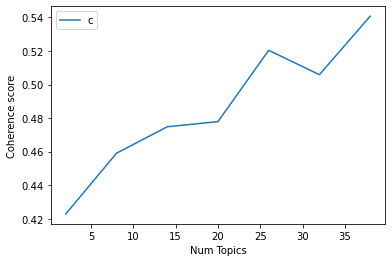

In [56]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4228
Num Topics = 8  has Coherence Value of 0.459
Num Topics = 14  has Coherence Value of 0.4748
Num Topics = 20  has Coherence Value of 0.4779
Num Topics = 26  has Coherence Value of 0.5204
Num Topics = 32  has Coherence Value of 0.5059
Num Topics = 38  has Coherence Value of 0.5407


In [63]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(6,
  '0.039*"candidato" + 0.032*"primero" + 0.025*"encuestar" + 0.023*"democrata" '
  '+ 0.023*"publicar" + 0.021*"dolar" + 0.019*"oficial" + 0.019*"lugar" + '
  '0.019*"presidencial" + 0.018*"debatir"'),
 (21,
  '0.054*"presidente" + 0.043*"elección" + 0.029*"elegir" + 0.026*"electoral" '
  '+ 0.024*"decir" + 0.023*"correar" + 0.022*"hacer" + 0.022*"podria" + '
  '0.015*"republicano" + 0.015*"boleta"'),
 (7,
  '0.059*"hacer" + 0.049*"ano" + 0.039*"pasar" + 0.035*"ganar" + 0.035*"ahora" '
  '+ 0.034*"presidente" + 0.026*"unir" + 0.024*"menos" + 0.022*"temer" + '
  '0.021*"creer"'),
 (3,
  '0.213*"votar" + 0.035*"personar" + 0.032*"solo" + 0.027*"futuro" + '
  '0.026*"luchar" + 0.021*"libertar" + 0.020*"bueno" + 0.020*"democratas" + '
  '0.020*"derecho" + 0.018*"vivir"'),
 (18,
  '0.070*"conservador" + 0.047*"liberal" + 0.023*"catolica" + 0.023*"grande" + '
  '0.023*"final" + 0.022*"guerra" + 0.018*"historia" + 0.017*"odiar" + '
  '0.015*"mal" + 0.015*"politica"'),
 (9,
  '0.344*"just

## Finding the dominant topic in each sentence

In [64]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.0868,"justice, democrats, ruth_bader, cancer, rbg, death, pastor, responsible, senate, pancreas","We honor the memory of Supreme Court Justice Ruth Bader Ginsburg. But to do so we must also honor her legacy of justice and equality for all people!! May she Rest In Peace, and we pray Congess doesn’t disgrace her memory by rushing to replace her. The nation has lost an iconic leader who should be mourned and celebrated.🙏🏼🇺🇸😢 Photos from Mexican Americans For Bidens post"
1,1,12.0,0.0570,"country, states, political, placer, basar, bible, equal, career, candidates, deal","Donald, recibirás del pueblo lo mismo que les has dado. Esto no fue nada. Verás el 3 de Noviembre... ¡El presidente NO estará contento con la recepción que recibió esta mañana en la Corte Suprema! Trump Recibe Abucheos y Cánticos Enojados Mientras Visitaba el Férretro de la Jueza Ruth Bader Ginsberg"
2,2,25.0,0.1338,"presidente, decir, nominar, republicano, senado, candidato, elección, senador, reemplazar, vacante","Esto es clave. Si es que ella cumple, estará frustando las esperanzas de Trump de empacar la Corte Suprema con otro retrógrado juez... El senador que está enfrascado en una tensa campaña de reelección podría ayudar a inclinar la balanza en contra de los planes egoístas del presidente. Malo Para Trump y McConnell: Otra Senadora Republicana Anuncia Que no Apoyará Candidato al Supremo Antes de Noviembre"
3,3,23.0,0.0703,"juez, confirmar, supremo, nombrar, cortar, apelación, mujer, asociar, ocupar, poner","Si eres o tienes amigos mujeres, gays o de otras minorías, esta Jueza es tu ENEMIGA. No a la confirmación... Amy Coney Barrett se descalificó a sí misma para ocupar un puesto vitalicio en el tribunal más alto de nuestra nación con sus respuestas muy elocuentes. La Nominada Por Trump a la Corte Suprema no es Apta y se Niega a Responder Preguntas Clave"
4,4,25.0,0.0642,"presidente, decir, nominar, republicano, senado, candidato, elección, senador, reemplazar, vacante","Cuídate el hígado Donny! Esas perretas de niño consentido no te llevarán a nada... La capacidad del presidente para impulsar a su reemplazo de Ginsburg a través del Senado se encontró con algunos problemas hoy, y no está contento. Trump se Enfurece por la Negativa de Susan Collins a Apoyar su Derecho a Ocupar el Escaño de la Corte Suprema de Ginsburg"
5,5,21.0,0.0792,"presidente, elección, elegir, electoral, decir, correar, hacer, podria, republicano, boleta","Todo depende de que los demócratas tomen al toro por los cuernos y actúen tan DURO como ellos... El ex republicano estaba muy emocionado de mostrarle a McConnell cómo se hizo jaque mate con su táctica de la Corte Suprema. McConnell Logró Destrozar la Esencia de Nuestra Corte Suprema, Pero Tenemos la Solución Para el 2021"
6,6,5.0,0.1910,"familia, personar, perder, ir, mayor, llamar, ninos, asi, tan, hablar","Esto es algo que todos SABEN, pero nadie lo había explicado de manera tan CLARA. Y así se atreven a hablar de DEMOCRACIA... El senador demócrata expuso las fuerzas corruptas que impulsan a Barrett a la Corte Suprema para que toda la nación las vea. Finalmente Alguien Explica Cómo Funciona la Red de ""Dinero Oscuro"" en la Elección de los Jueces"
7,7,25.0,0.0911,"presidente, decir, nominar, republicano, senado, candidato, elección, senador, reemplazar, vacante","Todo en esta vida tiene consecuencias, pero quizás más que nada, las ELECCIONES... Todo en esta vida tiene consecuencias, pero una de las cosas en las que esta m[axima m[as se aplica es en las elecciones, que pueden traernos muy buenas o muy graves consecuencias, algunas de las cuales no son evidentes de inmediato. Todo el que tenga dos dedos de frente se puede dar cuenta que la [... La Corte Suprema se Alia Con Trump Para Que el Congreso no Pueda Cumplir Sus Funciones. Pelosi Indignada"
8,8,5.0,0.0701,"familia, personar, perder, ir, mayor, llamar, ninos, asi, tan, hablar","Es tan grave el asunto que somo

## Find the most representative document for each topic

In [65]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6689,"votar, decidir, gran, poblar, comenzar, america, ser, izquierdo, muerte, socialista","“En carne viva” La batalla en aras a las próximas elecciones presidenciales en Estados Unidos está en carne viva, la jauría demócrata está desesperada, los tontos útiles y las ciberclarias están ansiosos, los socialistas rasgan sus vestiduras y los globalistas pactan con el mismo infierno por un milagro. La muerte de la legendaria jueza de la corte suprema no pudo ser más inoportuna para ello..."
1,1.0,0.2096,"nuevo, democratas, hoy, noticiar, mundial, chino, querer, ciudad, redar, fraude","Del muro de Noel Ojeda: Rompiendo Censuras: Nunca entenderé como a traidores a la Patria,se les rinden tributos solemnes a su trabajo en defensa al pueblo estadounidense como fue el caso del senador McCain y ahora la Jueza Ruth B Ginsburg,ambos marionetas traidoras del DEEP STATE .Entonces,Scalia otro juez de la Corte Suprema asesinado por la banda mafiosa de las familias del crimen del Cabal,..."
2,2.0,0.7344,"casa_blanca, payaso, presidente, necesitar, lograr, exponer, guerra, llaman_payaso, volver, servir","El payaso de la Casa Blanca acaba de negociar tres Acuerdos de Paz en Oriente Medio, algo que 71 años de intervención política y guerra interminable no lograron producir. El bufón de la Casa Blanca es el primer presidente que no nos ha involucrado en una guerra exterior desde Eisenhower. El payaso de la Casa Blanca ha tenido el mayor impacto en la economía, trayendo empleos y reduciendo el des..."
3,3.0,0.4951,"votar, personar, solo, futuro, luchar, libertar, bueno, democratas, derecho, vivir","Para responder a todos aquellos que dirían ′′ No puedo creer que votarías por Trump."" Bueno, gente escuchen! -No voy a votar por él. Voy a votar por la segunda enmienda. Voto por la próxima corte suprema de justicia. -Voto por el colegio electoral, y la República en la que vivimos. Voto por la policía, y la ley y el orden. -Voto por los militares, y por los veteranos que lucharon y murieron p..."
4,4.0,0.3024,"decir, poder, vez, empresa, escuchar, nunca, abortar, fiscal, momento, partir","Estas ratas pronto caerán.. #LuchaContraMafiaIzquierdista Congreso interrogará a los CEO de Facebook y Twitter en medio de las preocupaciones por la censura... ESTAMOS UNIDOS... Es tiempo de actuar!!! POR BOWEN XIAO (La Gran Época).- Los gigantes de la tecnología deben rendir cuentas por las potenciales prácticas de censura, dicen republicanos del Comité Judicial del Senado que recientemente v..."
5,5.0,0.4010,"familia, personar, perder, ir, mayor, llamar, ninos, asi, tan, hablar","¿Ignorabas esto? Los asintomáticos no contagian. En el siguiente video, El ""experto"" en Epidemias Anthony Fauci, a quien la Dra. Judy Mikovits responsabiliza como la mente detrás del gran negocio con el que están lucrando a través de lo que ella misma llama una #Plandemia, ahora se le ocurre decir que, en toda la historia de contagios de cualquier virus respiratorio, las personas «asintomátic..."
6,6.0,0.3551,"candidato, primero, encuestar, democrata, publicar, dolar, oficial, lugar, presidencial, debatir","TITULARES ""CADA TARDE"" 19 DE OCTUBRE, 2020 EL DIRECTOR NACIONAL DE INTELIGENCIA JOHN RATCLIFFE DIJO AYER, Y VOLVIO A REITERAR ESTA MANANA, QUE NO EXISTE NINGUNA EVIDENCIA DE QUE LOS RUSOS HAYAN TENIDO ALGO QUE VER CON LA COMPUTADORA DE HUNTER BIDEN Y SUS CORREOS ELEECTRONICOS. POR OTRA PARTE, LA CADENA FOX PUDO CORROBORAR LA AUTENCIDAD DE ALGUNOS DE LOS CORREOS ELECTRONICOS PUBLICADOS POR EL ..."
7,7.0,0.1889,"hacer, ano, pasar, ganar, ahora, presidente, unir, menos, temer, creer","DIOS BENDIGA A NUESTRO VICE- PRESIDENT PENCE , UN HOMBRE DE DIOS. 🇺🇸 El Vice-Presidente Mike Pence realiza gira pro-vida en varios estados! ➖El vicepresidente Mike Pence hizo una parada de campaña en Carolina del Norte para promover líderes en el movimiento pro-vida en una gira por varios estados patrocinada por Susan B. Anthony List. Pence defendió la ree

In [66]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [67]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"justice, democrats, ruth_bader, cancer, rbg, death, pastor, responsible, senate, pancreas",184.0,0.1752
1.0,12.0,"country, states, political, placer, basar, bible, equal, career, candidates, deal",23.0,0.0219
2.0,25.0,"presidente, decir, nominar, republicano, senado, candidato, elección, senador, reemplazar, vacante",11.0,0.0105
3.0,23.0,"juez, confirmar, supremo, nombrar, cortar, apelación, mujer, asociar, ocupar, poner",19.0,0.0181
4.0,25.0,"presidente, decir, nominar, republicano, senado, candidato, elección, senador, reemplazar, vacante",12.0,0.0114
5.0,21.0,"presidente, elección, elegir, electoral, decir, correar, hacer, podria, republicano, boleta",14.0,0.0133
6.0,5.0,"familia, personar, perder, ir, mayor, llamar, ninos, asi, tan, hablar",11.0,0.0105
7.0,25.0,"presidente, decir, nominar, republicano, senado, candidato, elección, senador, reemplazar, vacante",13.0,0.0124
8.0,5.0,"familia, personar, perder, ir, mayor, llamar, ninos, asi, tan, hablar",52.0,0.0495
9.0,23.0,"juez, confirmar, supremo, nombrar, cortar, apelación, mujer, asociar, ocupar, poner",157.0,0.1495
